# Noise models on Rigetti

This notebook shows how to construct a noise model from device calibration data for Rigetti Ankaa-2. We compare the measurement outcomes of circuits run on a noisy simulator with the same circuits run on quantum processing units (QPUs), to show that simulating circuits with noise models more closely mimics QPUs.

**Before you begin**: We recommend being familiar with [Noise models on Amazon Braket.](https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/braket_features/Noise_models/Noise_models_on_Amazon_Braket.ipynb)
Additionally, users should be familiar with [Running quantum circuits on QPU devices](https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/getting_started/2_Running_quantum_circuits_on_QPU_devices/2_Running_quantum_circuits_on_QPU_devices.ipynb). 

### Table of Contents

- Noise model for Rigetti
  - Loading device calibration data
  - Comparing noisy simulator results to QPU results
  - Smaller noise models compared to QPU results

In [1]:
import numpy as np
import pandas as pd

from braket.aws import AwsDevice
from braket.circuits import Circuit, Gate
from braket.circuits.noise_model import GateCriteria, NoiseModel, ObservableCriteria
from braket.circuits.noises import (
    BitFlip,
    Depolarizing,
    TwoQubitDepolarizing,
)
from braket.devices import Devices, LocalSimulator

Braket provides access to hardware providers' reported calibration data. 
This can be used to construct noise models to approximate the behavior of the QPU when running circuits on a noisy simulator.
In this tutorial, we focus on local noise models with no crosstalk interactions. Real devices can have crosstalk and unexpected effects that can further degrade the results.

The Ankaa-2 calibration data is available on the Braket devices page. Under qubit specs, the calibration data include the qubit index, with corresponding values for the $T_1$, $T_2$, fidelity from randomized benchmarking (fRB),  fidelity from simultaneous randomized benchmarking (fsRB), and readout fidelity (fRO).
Under "edge specs", the data includes the RB fidelity for two qubit gates for each connected edge in the device topology.

**One-qubit calibration data (Qubit specs)**
<div align=center><img src="ankaa2_qubit_specs.png"/></div>


**Two-qubit calibration data (Edge specs)**
<div align=center><img src="ankaa2_edge_specs.png"/></div>

We can programmatically access all the calibration data with the Braket SDK. First we load the AwsDevice using the ARN for Rigetti Ankaa-2.

In [2]:
rigetti = AwsDevice(Devices.Rigetti.Ankaa2)

The properties dictionary contains one- and two-qubit calibration data. 

In [3]:
one_qubit_data = rigetti.properties.standardized.oneQubitProperties
two_qubit_data = rigetti.properties.standardized.twoQubitProperties

For Ankaa-2, we can get all qubit indices with `one_qubit_data.keys()` or with `rigetti.topology_graph.nodes`.

The keys of the two qubit dictionary are the connected qubit pairs separated by a hyphen. 
For example, if qubit 0 and 1 are connected the key is "0-1".


#### One-qubit noise 

Let's look at the one qubit calibration data for qubit 0.

In [5]:
one_qubit_data["0"]

OneQubitProperties(T1=CoherenceTime(value=8.645474408067754e-06, standardError=None, unit='S'), T2=CoherenceTime(value=1.2710111632672265e-05, standardError=None, unit='S'), oneQubitFidelity=[Fidelity1Q(fidelityType=FidelityType(name='RANDOMIZED_BENCHMARKING', description=None), fidelity=0.998913376867117, standardError=2.7016428586132974e-05), Fidelity1Q(fidelityType=FidelityType(name='SIMULTANEOUS_RANDOMIZED_BENCHMARKING', description=None), fidelity=0.9975435377199546, standardError=0.00015343141167926104), Fidelity1Q(fidelityType=FidelityType(name='READOUT', description=None), fidelity=0.9219999999999999, standardError=None)])

For each qubit, there are various metrics of the quality:

- **T1**: Thermal relaxation time is related to the time it takes for the excited state, |1⟩, to decay into the ground state, |0⟩. The probability of remaining in the excited state is $p(|1⟩)\sim e^{-t/T_1}$

- **T2**: The dephasing time, is the decay constant for the scale for a |+⟩ state to decohere into the completely mixed state. $p(|+⟩)\sim e^{-t/T_2}$ 

- **Fidelity (RB)**: Single-qubit randomized benchmarking fidelities. RB fidelity quantifies the average gate fidelity where the average is over all Clifford gates. RB describes an *effective* noise model with gate-independent depolarizing noise on each Clifford gate.

- **Fidelity (sRB)**: Single-qubit simultaneous randomized benchmarking fidelities. These are extracted by running single-qubit RB on all qubits simultaneously. Note that we expect the sRB fidelity to be lower than standard RB fidelity due to non-local crosstalk type noise on the device. 

- **Readout fidelity**: Single-qubit readout fidelities describes the probability of a bit flip error before readout in the computational basis. The readout fidelity is related to the probability of correctly measuring the ground state and excited states respectively, e.g. $f_{RO} =\frac{p(0|0)+p(1|1)}{2}$

Now that we know how to extract and use the calibration data, we can build a simple noise model. For every qubit we will add:
- amplitude dampening noise with probability $p= 1-e^{-t/T_1}$ for every gate
- phase dampening noise with probability $p= 0.5(1-e^{-t/T_2})$ for every gate
- depolarizing noise with probability $p=1-f_{sRB}$ (from simultaneous RB fidelity) for  every gate
- readout bit flip noise with probability $p=1-f_{RO}$ to measurements 

Technically, the sRB fidelity already includes effects from $T_1$/$T_2$, however to be explicit we add these as separate terms. In a sense, this model might overestimate the noise on the QPU.  

To create the noise model, we iterate over all qubits keys in `one_qubit_data`

In [6]:
noise_model = NoiseModel()

# Readout Noise Model
for q, data in rigetti.properties.standardized.oneQubitProperties.items():
    try:
        readout_error = 1 - data.oneQubitFidelity[2].fidelity  # readout
        noise_model.add_noise(BitFlip(readout_error), ObservableCriteria(qubits=int(q)))

        depolarizing_rate = (
            1 - data.oneQubitFidelity[1].fidelity
        )  # SIMULTANEOUS_RANDOMIZED_BENCHMARKING
        noise_model.add_noise(Depolarizing(probability=depolarizing_rate), GateCriteria(qubits=q))
    except:
        pass

In [7]:
num_params = sum(len(item.noise.parameters) for item in noise_model.instructions)
print(f"Number of terms in noise model is: {len(noise_model.instructions)}")
print(f"Number of parameters in noise model is: {num_params}")

Number of terms in noise model is: 167
Number of parameters in noise model is: 167


#### Two-qubit noise 
Next we consider adding two-qubit noise to the model. 

Let's first look at the data provided in the Ankaa-2 device calibration data. On the first connect, "0-1", the properties are:

In [8]:
two_qubit_data["0-1"]

TwoQubitProperties(twoQubitGateFidelity=[GateFidelity2Q(direction=None, gateName='ISWAP', fidelity=0.9773180863130815, standardError=0.00408287380553746, fidelityType=FidelityType(name='INTERLEAVED_RANDOMIZED_BENCHMARKING', description=None))])

Here, we see the fidelity per gate (ISWAP or CZ) and the associated standard error. 

Next we loop over the entries in the `two_qubit_data` dictionary and add two-qubit depolarizing noise to the model. Notice that Ankaa-2 has symmetric connections ("0-1" and "1-0") so we need to add noise in both directions.

In [9]:
# Two-qubit noise
for pair, data in two_qubit_data.items():  # iterate over qubit connections
    # parse strings "0-1" to integers [0, 1]
    q0, q1 = (int(s) for s in pair.split("-"))
    try:
        if data.twoQubitGateFidelity[0].gateName == "ISWAP":
            phase_rate = 1 - data.twoQubitGateFidelity[0].fidelity
            noise_model.add_noise(
                TwoQubitDepolarizing(phase_rate),
                GateCriteria(Gate.ISwap, [(q0, q1), (q1, q0)]),  # symmetric connections
            )
    except:
        pass

In [10]:
num_params = sum(len(item.noise.parameters) for item in noise_model.instructions)
print(f"Number of terms in noise model is: {len(noise_model.instructions)}")
print(f"Number of parameters in noise model is: {num_params}")

Number of terms in noise model is: 274
Number of parameters in noise model is: 274


### Compare circuits run on device vs simulator with a noise model

Let's just look at the first 5 qubits. Note that to ensure the noise model applied T1 and T2 noise during the time between gate, we manually add identity gates to each moment.

In [11]:
np.random.seed(42)

circ = Circuit().rx(0, 0.5).rz(1, 0.5).rz(2, 0.5).rx(0, np.pi).rx(1, np.pi).rx(2, np.pi).iswap(0, 1)
print(circ)

T  : │     0      │     1      │    2    │
      ┌──────────┐ ┌──────────┐ ┌───────┐ 
q0 : ─┤ Rx(0.50) ├─┤ Rx(3.14) ├─┤ ISWAP ├─
      └──────────┘ └──────────┘ └───┬───┘ 
      ┌──────────┐ ┌──────────┐ ┌───┴───┐ 
q1 : ─┤ Rz(0.50) ├─┤ Rx(3.14) ├─┤ ISWAP ├─
      └──────────┘ └──────────┘ └───────┘ 
      ┌──────────┐ ┌──────────┐           
q2 : ─┤ Rz(0.50) ├─┤ Rx(3.14) ├───────────
      └──────────┘ └──────────┘           
T  : │     0      │     1      │    2    │


In [12]:
noisy_circ = noise_model.apply(circ)

print(noisy_circ)

T  : │     0      │     1      │            2            │
      ┌──────────┐ ┌──────────┐ ┌───────┐ ┌─────────────┐ 
q0 : ─┤ Rx(0.50) ├─┤ Rx(3.14) ├─┤ ISWAP ├─┤ DEPO(0.023) ├─
      └──────────┘ └──────────┘ └───┬───┘ └──────┬──────┘ 
      ┌──────────┐ ┌──────────┐ ┌───┴───┐ ┌──────┴──────┐ 
q1 : ─┤ Rz(0.50) ├─┤ Rx(3.14) ├─┤ ISWAP ├─┤ DEPO(0.023) ├─
      └──────────┘ └──────────┘ └───────┘ └─────────────┘ 
      ┌──────────┐ ┌──────────┐                           
q2 : ─┤ Rz(0.50) ├─┤ Rx(3.14) ├───────────────────────────
      └──────────┘ └──────────┘                           
T  : │     0      │     1      │            2            │


In [13]:
simulator = LocalSimulator()  # noise free simulator
task = simulator.run(circ, shots=10_000)
free_probs = task.result().measurement_probabilities

In [14]:
noisy_simulator = LocalSimulator("braket_dm")
noisy_task = noisy_simulator.run(noisy_circ, shots=10_000)
noisy_probs = noisy_task.result().measurement_probabilities

<div class="alert alert-block alert-info">
<b>Note:</b> The below section runs tasks on the Rigetti Ankaa-2 device. When you run this notebook, make sure the device is currently available. You can find QPU availability windows on the <a href="https://us-west-1.console.aws.amazon.com/braket/home?region=us-west-1#/devices">Devices page</a> in the Amazon Braket Console.
</div>

<div class="alert alert-block alert-info">
<b>Note:</b> Running the circuit below will result in charges on your AWS account.
</div>

In [15]:
rigetti_task = rigetti.run(circ, shots=10_000, disable_qubit_rewiring=True)
rigetti_result = rigetti_task.result()
rigetti_probs = rigetti_result.measurement_probabilities

In [16]:
free_sim = pd.DataFrame.from_dict(free_probs, orient="index").rename(columns={0: "free_sim"})
noisy_sim = pd.DataFrame.from_dict(noisy_probs, orient="index").rename(columns={0: "noisy_sim"})
Ankaa = pd.DataFrame.from_dict(rigetti_probs, orient="index").rename(columns={0: "Ankaa-2"})
df = Ankaa.join(noisy_sim).join(free_sim)
df

,Ankaa-2,noisy_sim,free_sim
110,0.1866,NaN,NaN
011,0.0996,0.0061,NaN
001,0.0528,0.0055,NaN
111,0.4555,0.9214,0.9384
101,0.1254,0.0670,0.0616
010,0.0229,NaN,NaN
100,0.0443,NaN,NaN
000,0.0129,NaN,NaN


We can compute the fidelity between the free simulation and Rigetti, as well as the noisy simulation and Rigetti. 

In [17]:
def fidelity(p, q):
    return np.sum(np.sqrt(p * q))


f_free_Ankaa = fidelity(df["free_sim"], df["Ankaa-2"])
f_noisy_Ankaa = fidelity(df["noisy_sim"], df["Ankaa-2"])

print(f"\nTotal fidelity between Ankaa-2 and noise-free simulator is {f_free_Ankaa}")
print(f"\nTotal fidelity between Ankaa-2 and noisy simulator is {f_noisy_Ankaa}")


Total fidelity between Ankaa-2 and noise-free simulator is 0.7416798056649024

Total fidelity between Ankaa-2 and noisy simulator is 0.7811919904651835


To better visualize, we can also plot the output probability distributions from each circuit:

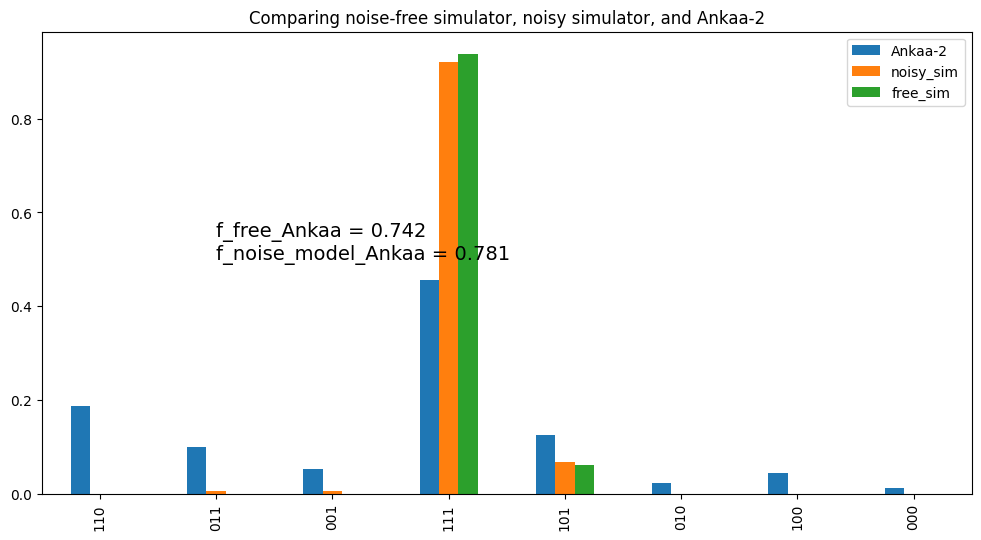

In [18]:
import matplotlib.pyplot as plt

%matplotlib inline

df.plot.bar(
    title="Comparing noise-free simulator, noisy simulator, and Ankaa-2",
    figsize=(12, 6),
)

text = f"f_free_Ankaa = {f_free_Ankaa:.3f} \nf_noise_model_Ankaa = {f_noisy_Ankaa:.3f}"
plt.text(1, 0.5, text, fontsize=14)
plt.show()

We confirm that the simulator with a noise model is closer to the distribution produced by Ankaa-2.

### Smaller, reduced noise models

The full Rigetti Ankaa-2 noise model contains due to non-uniform qubit noise. We can obtain simpler, smaller noise models by coarse graining the model above.

Here, we consider taking the average over all qubits for the $T_1$, $T_2$, depolarizing, and readout depolarizing rates. This is a substantially smaller noise model, but may be less accurate. 

We use the `from_filter` function to extract all instructions with amplitude dampening noise in the model. We then compute the mean of the error probabilities. 

In [19]:
avg_depo = np.mean(
    [n.noise.parameters for n in noise_model.from_filter(noise=Depolarizing).instructions]
)
avg_readout = np.mean(
    [n.noise.parameters for n in noise_model.from_filter(noise=BitFlip).instructions]
)

Now we construct a new noise model with the mean values above:

In [20]:
simple_noise_model = NoiseModel()
simple_noise_model.add_noise(Depolarizing(avg_depo), GateCriteria())
simple_noise_model.add_noise(BitFlip(avg_readout), ObservableCriteria())

print(simple_noise_model)

Gate Noise:
  Depolarizing(0.010099107504894678), GateCriteria(None, None)
Readout Noise:
  BitFlip(0.06397619047619048), ObservableCriteria(None, None)


We can see the resultant circuits contain qubit-independent noise:

In [21]:
simple_noisy_circ = simple_noise_model.apply(circ)
print(simple_noisy_circ)

T  : │             0             │             1             │           2            │
      ┌──────────┐ ┌────────────┐ ┌──────────┐ ┌────────────┐ ┌───────┐ ┌────────────┐ 
q0 : ─┤ Rx(0.50) ├─┤ DEPO(0.01) ├─┤ Rx(3.14) ├─┤ DEPO(0.01) ├─┤ ISWAP ├─┤ DEPO(0.01) ├─
      └──────────┘ └────────────┘ └──────────┘ └────────────┘ └───┬───┘ └────────────┘ 
      ┌──────────┐ ┌────────────┐ ┌──────────┐ ┌────────────┐ ┌───┴───┐ ┌────────────┐ 
q1 : ─┤ Rz(0.50) ├─┤ DEPO(0.01) ├─┤ Rx(3.14) ├─┤ DEPO(0.01) ├─┤ ISWAP ├─┤ DEPO(0.01) ├─
      └──────────┘ └────────────┘ └──────────┘ └────────────┘ └───────┘ └────────────┘ 
      ┌──────────┐ ┌────────────┐ ┌──────────┐ ┌────────────┐                          
q2 : ─┤ Rz(0.50) ├─┤ DEPO(0.01) ├─┤ Rx(3.14) ├─┤ DEPO(0.01) ├──────────────────────────
      └──────────┘ └────────────┘ └──────────┘ └────────────┘                          
T  : │             0             │             1             │           2            │


We run the circuit on a noisy simulator below

In [22]:
simple_noisy_task = noisy_simulator.run(simple_noisy_circ, shots=100_000)
simple_noisy_probs = simple_noisy_task.result().measurement_probabilities

and add it to the previous dataframe

In [23]:
simple_noisy_sim = pd.DataFrame.from_dict(simple_noisy_probs, orient="index").rename(
    columns={0: "simple_noisy_sim"}
)
df = df.join(simple_noisy_sim)
df

,Ankaa-2,noisy_sim,free_sim,simple_noisy_sim
110,0.1866,NaN,NaN,0.01230
011,0.0996,0.0061,NaN,0.01795
001,0.0528,0.0055,NaN,0.00156
111,0.4555,0.9214,0.9384,0.89030
101,0.1254,0.0670,0.0616,0.07659
010,0.0229,NaN,NaN,0.00019
100,0.0443,NaN,NaN,0.00108
000,0.0129,NaN,NaN,0.00003


We compute the fidelity between the simple noise model and the QPU:

In [24]:
f_simple = fidelity(df["simple_noisy_sim"], df["Ankaa-2"])

print(f"\nTotal fidelity between Ankaa-2 and full noise model is: {f_noisy_Ankaa}")
print(f"\nTotal fidelity between Ankaa-2 and simple noise model is: {f_simple}")
print(f"\nTotal fidelity between Ankaa-2 and noise-free is: {f_free_Ankaa}")


Total fidelity between Ankaa-2 and full noise model is: 0.7811919904651835

Total fidelity between Ankaa-2 and simple noise model is: 0.8437069124308016

Total fidelity between Ankaa-2 and noise-free is: 0.7416798056649024


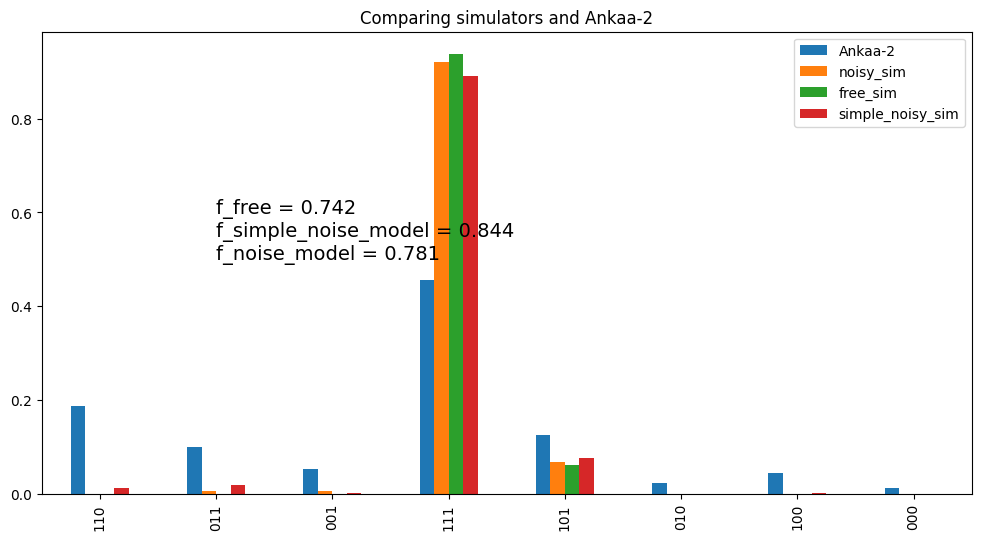

In [25]:
df.plot.bar(title="Comparing simulators and Ankaa-2", figsize=(12, 6))
text = f"f_free = {f_free_Ankaa:.3f} \nf_simple_noise_model = {f_simple:.3f} \nf_noise_model = {f_noisy_Ankaa:.3f}"
plt.text(1, 0.5, text, fontsize=14)
plt.show()

We see that compared to the full noise model, the simple model is less accurate, however, it is still a significant improvement over the noise-free case and has far fewer parameters in the model. 

## Summary

In this notebook, we showed how to construct a noise model for Rigetti Ankaa-2 based only on the available calibration data.
We used a coarse assumption of gate-independent single-qubit depolarizing noise and gate-dependant two-qubit noise. Our qubit-dependent model could be improved in many ways. We could add gate-dependence noise, or change the depolarizing channel to Pauli channels. 